In [71]:
%load_ext autoreload
%autoreload 2
import torchshow as ts
import os
import cv2
import pickle
from IPython.display import Video
import glob
import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import util.constants as constants

sys.path.append(constants.ROOT)
sys.path.append(constants.SRC)
sys.path.append(constants.MMAE)

from src.modules.picanet import Unet
from util.saliency_util import get_heatmap_from_ann_file
from train_picanet import picanet_cfg
import util.general_utils as utils
from src.modules.mmae import initialize_mmae
from dataset import MetaworldData
from torchvision import transforms


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualize the saliency predictions

In [52]:
# load in the pretrained saliency predictor
task = 'drawer-open-v2'
cfg = picanet_cfg[2]
model = Unet(cfg).eval()
ckpt_file = os.path.join(constants.ROOT, f"pretrained_models/{task}/fixation_model_picanet_cfg_2.pt")
model.load_state_dict(torch.load(ckpt_file))

<All keys matched successfully>

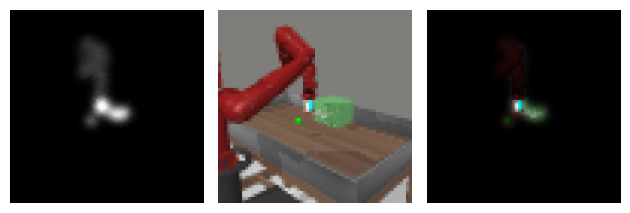

In [51]:
img = plt.imread("frame_000.png")[:,:,:3]
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA) # HxWxC
img = img.transpose(2,0,1)[None] # 1xCxHxW

with torch.no_grad():
    inp_ = torch.from_numpy(img).float()
    pred, _ = model(inp_)
    pred = pred[-1]
    
masked_img = pred.repeat(1,3,1,1) * img
ts.show([pred.squeeze(), img.squeeze(), masked_img.squeeze()]) 

## Visualize the MultiMAE predictions

In [67]:
def make_color(sal):
    sal = sal.squeeze().cpu().detach().numpy()
    heatmap = sal * 255
    heatmap = heatmap.astype("uint8")
    h, w = sal.shape
    heatmap = cv2.resize(heatmap, (w, h))
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Create mask
    threshold = 5
    alpha = 0.7
    mask = np.where(heatmap <= threshold, 1, 0)
    mask = np.reshape(mask, (h, w, 1))
    mask = np.repeat(mask, 3, axis=2)

    # Merge images
    merge = heatmap_color
    merge = merge.astype("uint8")
    saliency_viz = torch.from_numpy(merge / 255.0).unsqueeze(0).permute(0, 3,1,2)
    return saliency_viz

In [72]:
def visualize_predictions(model, in_domains, obs, saliency=None, show=False):
    to_show_rgb = []
    to_show_saliency = []
    with torch.no_grad():
        for i in range(3):
            input_dict = {}
            input_dict["rgb"] = obs.cuda()
            if saliency is None:
                saliency = torch.zeros_like(input_dict["rgb"])[:, 0:1]

            input_dict["saliency"] = saliency

            num_encoded_tokens = 32  # the number of visible tokens
            alphas = 1.0  # Dirichlet concentration parameter

            preds, masks = model.forward(
                input_dict,
                mask_inputs=True,  # True if forward pass should sample random masks
                num_encoded_tokens=num_encoded_tokens,
                alphas=alphas,
            )

            masks_ = masks
            mask_rgb = utils.get_masked_image(utils.denormalize(input_dict["rgb"]), masks_["rgb"], image_size=64, patch_size=8)
            pred_img = utils.get_pred_with_input(input_dict["rgb"], preds["rgb"], masks_["rgb"], image_size=64, patch_size=8)
        

            if "saliency" in in_domains:
                mask_saliency = utils.get_masked_image(input_dict["saliency"], masks_["saliency"], image_size=64, patch_size=8)
                pred_saliency = utils.get_pred_with_input(input_dict["saliency"], preds["saliency"], masks_["saliency"], image_size=64, patch_size=8).cuda()
            

            show_rgb = [
                utils.denormalize(obs) * 255.0,
                mask_rgb * 255.0,
                utils.denormalize(pred_img) * 255.0,
            ]
            if i != 0:
                show_rgb = show_rgb[1:]
        
            show_rgb = list(zip(*show_rgb))
            show_rgb = [list(elem) for elem in show_rgb]
            to_show_rgb.extend(show_rgb[0])
            
            saliency_viz = make_color(saliency)
            
            if "saliency" in in_domains:
                mask_saliency = utils.get_masked_image(saliency_viz, masks_["saliency"], image_size=64, patch_size=8)
                pred_saliency = utils.get_pred_with_input(saliency.float(), preds["saliency"], masks_["saliency"], image_size=64, patch_size=8).cuda()
                
                pred_saliency = make_color(pred_saliency)
                    
            if "saliency" in in_domains:
                show_saliency = [saliency_viz, mask_saliency * 255.0, pred_saliency]
                if i != 0:
                    show_saliency = show_saliency[1:]

                show_saliency = list(zip(*show_saliency))
                show_saliency = [list(elem) for elem in show_saliency]
                to_show_saliency.extend(show_saliency[0])
                
        to_show = [to_show_rgb, to_show_saliency]
        return to_show

In [76]:
%%capture
task = "drawer-open-v2"
all_checkpoints = glob.glob(os.path.join(constants.MMAE, "output_dir", f"{task}_with_saliency", 'checkpoint-*.pth'))
latest_ckpt = -1
for ckpt in all_checkpoints:
    t = ckpt.split('-')[-1].split('.')[0]
    if t.isdigit():
        latest_ckpt = max(int(t), latest_ckpt)
                    
mmae_model = initialize_mmae(
    load_from_ckpt=True, 
    ckpt_path=os.path.join(constants.MMAE, "output_dir", f"{task}_with_saliency", f"checkpoint-{latest_ckpt}.pth")
)
mmae_model = mmae_model.cuda()

torch.Size([1, 3, 64, 64]) torch.Size([1, 1, 64, 64])


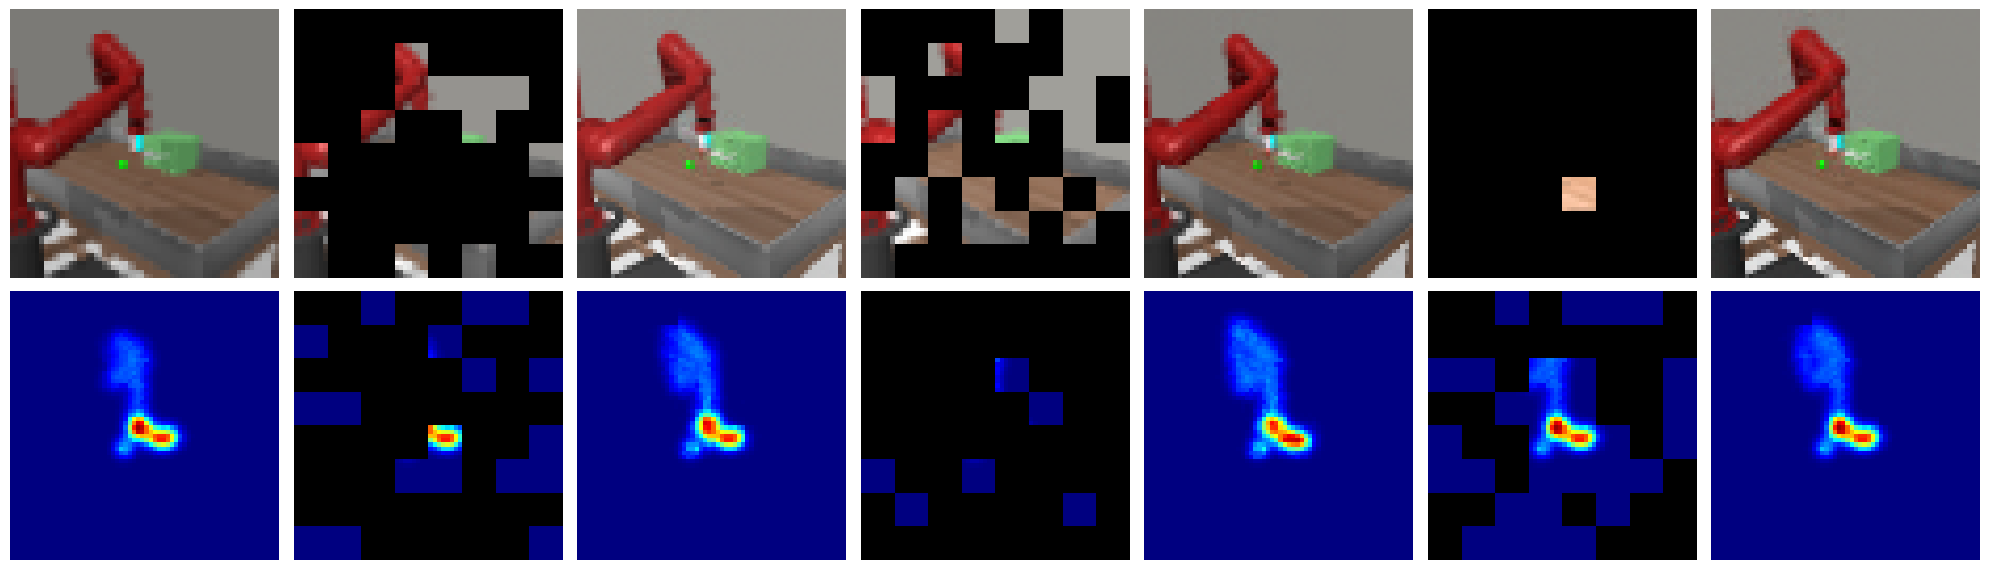

In [78]:
upsample_m = torch.nn.modules.upsampling.Upsample(scale_factor=(224 / 64, 224 / 64), mode="nearest").to("cuda")
downsample_m = torch.nn.modules.upsampling.Upsample(scale_factor=(64 / 224, 64 / 224), mode="nearest").to("cuda")

transform_train = transforms.Compose(
    [
        # transforms.Resize(224),
        # lambda x: x / 255.0,  # this is only if the image isn't normalized already
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

img_input = transform_train(torch.from_numpy(img)).cuda()
img_input = downsample_m(img_input)
saliency_input = downsample_m(pred).cuda()
print(img_input.shape, saliency_input.shape)

to_show = visualize_predictions(
    mmae_model, 
    ["rgb", "saliency"], 
    img_input, 
    saliency_input, 
    show=False
)
ts.show(to_show, tight_layout=True, figsize=(20, 2*3))